In [1]:
from typing import SupportsFloat, Any

from gymnasium.core import ActType, ObsType

from src.reinforcement_learning.core.infos import InfoDict
from tmp_mp import main

In [1]:
main()

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
vec_env = make_vec_env("HalfCheetah-v4", n_envs=4)

model = PPO("MlpPolicy", vec_env, use_sde=True, sde_sample_freq=100, verbose=2)
model.learn(total_timesteps=250000)
model.save("ppo_cartpole")

del model  # remove to demonstrate saving and loading

model = PPO.load("ppo_cartpole")

obs = vec_env.reset()
# while True:
#     action, _states = model.predict(obs)
#     obs, rewards, dones, info = vec_env.step(action)
#     vec_env.render("human")

In [16]:
model.target_entropy

In [14]:
import torch
import numpy as np

rollout_data = np.random.random((2500, 32, 17))

In [15]:
%%timeit
for i in range(len(rollout_data)):
    tensor = torch.tensor(rollout_data[i], device='cuda')

In [6]:
import types
import numpy as np
import torch
from torch import nn


class A(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(17, 17)

        self.forward = self.linear.forward

    # def forward(self, x):
    #     return self.linear(x)


test_data = torch.tensor(np.random.random((2500, 1024, 17))).float()

a = A()

In [7]:
%%timeit

for i in range(len(test_data)):
    a(test_data[i])

In [8]:
%%timeit

for i in range(len(test_data)):
    a(test_data[i]).detach()

In [1]:
from src.torch_device import get_torch_device

get_torch_device()

In [ ]:
import gymnasium

gymnasium.make('Ant-v4', )

In [ ]:
%load_ext autoreload
%autoreload 2

def record_video():
    import torch
    from tqdm import tqdm
    from src.reinforcement_learning.gym.singleton_vector_env import as_vec_env
    import gymnasium
    from gymnasium.wrappers import AutoResetWrapper, RecordVideo
    from src.model_db.tiny_model_db import TinyModelDB
    from src.reinforcement_learning.algorithms.policy_mitosis.mitosis_policy_info import MitosisPolicyInfo
    from src.reinforcement_learning.core.policy_construction import PolicyConstruction
    from src.datetime import get_current_timestamp

    record_env, _ = as_vec_env(gymnasium.make('Ant-v4', render_mode='rgb_array'))

    policy_db = TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/Ant-v4/mitosis-2024-06-10_19.43.13')
    print(policy_db)

    policy_entry = list(sorted(policy_db.all_entries(), key=lambda entry: entry['model_info']['score']))[-2]
    # policy_entry = policy_db.fetch_entry('2024-06-10_22.13.57~PJHPLG')
    policy_info: MitosisPolicyInfo = policy_entry['model_info']
    print(policy_entry)

    policy, _, record_env = PolicyConstruction.init_from_info(policy_info['initialization_info'], record_env)

    policy_db.load_model_state_dict(policy_entry['model_id'], policy)

    try:
        record_env.metadata['render_fps'] = 30
        record_env = AutoResetWrapper(
            RecordVideo(record_env, video_folder=rf'C:\Users\domin\Videos\rl\{get_current_timestamp()}',
                        episode_trigger=lambda ep_nr: True)
        )

        def record(max_steps: int):
            with torch.no_grad():
                obs, info = record_env.reset()
                for step in tqdm(range(max_steps)):
                    actions_dist, _ = policy.process_obs(torch.tensor(obs, device='cpu'))
                    actions = actions_dist.get_actions(deterministic=True).cpu().numpy()
                    obs, reward, terminated, truncated, info = record_env.step(actions)

        record(50_000)
    except KeyboardInterrupt:
        print('keyboard interrupt')
    finally:
        print('closing record_env')
        record_env.close()
        print('record_env closed')


record_video()

In [14]:
from torch import nn

from src.networks.core.net import Net
from src.networks.multihead_self_attention import MultiheadSelfAttention
from src.networks.core.seq_net import SeqNet
from src.networks.skip_nets.additive_skip_connection import AdditiveSkipConnection

device = 'cuda:0'

transformer_encoder_net = SeqNet.from_layer_provider(
    layer_provider=lambda layer_nr, is_last_layer, in_features, out_features:
    nn.Sequential(
        AdditiveSkipConnection(MultiheadSelfAttention(
            embed_dim=in_features,
            num_heads=8,
        )),
        nn.LayerNorm(in_features),
        AdditiveSkipConnection(Net.seq_as_net(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, out_features),
            nn.ReLU(),
        )),
        nn.LayerNorm(out_features),
    ),
    num_layers=6,
    num_features=512,
).to(device)

transformer_encoder_net.out_shape
transformer_encoder_net(torch.tensor(np.random.random((7, 5, 512))).to(device).float()).shape

In [2]:
transformer_encoder = nn.TransformerEncoder(
    nn.TransformerEncoderLayer(
        d_model=512,
        nhead=8,
        dropout=0,
    ),
    num_layers=6
).to(device)

In [3]:
import numpy as np
import torch
data1 = torch.Tensor(np.random.random((100, 4, 512))).to(device)

In [6]:
%%timeit -r 15 -n 500
transformer_encoder_net(data1)

In [7]:
%%timeit -r 15 -n 500
transformer_encoder(data1)

In [4]:
data2 = torch.Tensor(np.random.random((100, 64, 512))).to(device)

In [5]:
%%timeit -r 15 -n 200
transformer_encoder_net(data2)

In [6]:
%%timeit -r 15 -n 200
transformer_encoder(data2)

In [4]:
data3 = torch.Tensor(np.random.random((100, 512, 512))).to(device)

In [ ]:
%%timeit -r 5 -n 50
transformer_encoder_net(data3)

In [ ]:
%%timeit -r 5 -n 50
transformer_encoder(data3)

In [20]:
import itertools
import numpy as np

def relu(x):
    return x * (x > 0)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

factors = np.array([1, 2, 5])
num_iterations = 10000
for d in np.concatenate((factors, factors * 10, factors * 100, factors * 1000, np.array([10_000]))):
    sum_ = 0
    for _ in range(num_iterations):
        v1 = (np.random.rand(d) - 0.5) * 2
        v2 = (np.random.rand(d) - 0.5) * 2
        
        v1 /= np.linalg.norm(v1)
        v2 /= np.linalg.norm(v2)
        
        v1 = leaky_relu(v1)
        v2 = leaky_relu(v2)
        
        sum_ += np.abs(np.inner(v1, v2))
    
    print(f'd={d:>5}: {sum_ / num_iterations}')

In [3]:
from src.networks.global_pooling import GlobalAveragePooling
from src.networks.core.tensor_shape import TensorShape
%load_ext autoreload
%autoreload 2

from src.networks.core.net import Net
from src.networks.skip_nets.dense_skip_net import DenseSkipNet
from torch import nn
import torch
import numpy as np


    
def make_dense_block(in_features: int, num_layers: int, growth_rate: int = 32):
    return DenseSkipNet.from_layer_provider(
        lambda layer_nr, is_last_layer, in_channels, out_channels:
            Net.seq_as_net(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels, 4 * growth_rate, 1),
                nn.BatchNorm2d(4 * growth_rate),
                nn.ReLU(),
                nn.Conv2d(4 * growth_rate, growth_rate, 3, padding='same')
            ),
        in_size=in_features,
        out_sizes=[growth_rate] * num_layers,
        feature_dim_index=1,
    )

def make_transition_layer(in_features: int):
    return nn.Sequential(
        nn.Conv2d(in_features, int(in_features / 2), 1),
        nn.AvgPool2d(2, 2),
    )

dense_net_121 = Net.provider_seq_as_net(
    3,
    lambda in_f: nn.Conv2d(in_f, 64, 7, 2),
    lambda in_f: nn.MaxPool2d(3, 2),
    lambda in_f: make_dense_block(in_f, 6),
    lambda in_f: make_transition_layer(in_f),
    lambda in_f: make_dense_block(in_f, 12),
    lambda in_f: make_transition_layer(in_f),
    lambda in_f: make_dense_block(in_f, 24),
    lambda in_f: make_transition_layer(in_f),
    lambda in_f: make_dense_block(in_f, 16),
    lambda in_f: GlobalAveragePooling((2, 3)),
    lambda in_f: nn.Linear(in_f, 1000)
)


In [30]:
import sympy as sp
expr = sp.Symbol('features') + 1



In [1]:
tuple((1, 2))

In [1]:
import torch
import numpy as np

In [2]:
data = np.random.random((5000, 128, 255))

In [6]:
%%timeit

torch_data = torch.tensor(data)
results = []

for i in range(0, 5000, 500):
    result = torch_data[i:i+500].mean()
    results.append(result)

In [7]:
%%timeit

torch_data = torch.tensor(data)
results = []

for i in range(0, 5000, 500):
    result = torch.as_tensor(torch_data[i:i+500])
    results.append(result)

In [17]:
%%timeit

results = []

for i in range(0, 5000, 500):
    result = torch.tensor(data[i:i+500], device='cuda')
    results.append(result)

In [8]:

torch_data = torch.tensor(data)



In [10]:
%%timeit

results = []

for i in range(0, 5000, 500):
    result = torch_data[i:i+500].to('cuda').mean()
    results.append(result)

In [8]:
from stable_baselines3.common.vec_env import SubprocVecEnv
import gymnasium as gym

from stable_baselines3 import PPO

env = SubprocVecEnv([lambda: gym.make("HalfCheetah-v4", render_mode=None, **{'forward_reward_weight': 1.25, 'ctrl_cost_weight': 0.001 })] * 16)

model = PPO("MlpPolicy", env, verbose=10, target_kl=0.025, batch_size=500, n_steps=2500)

import cProfile

pr = cProfile.Profile()
pr.enable()
model.learn(total_timesteps=10_000 * 16)
pr.disable()
pr.dump_stats('profile_stats_sb3.pstat')

In [6]:
from src.module_analysis import count_parameters

count_parameters(model.policy)

In [1]:
from gymnasium.vector import AsyncVectorEnv, SyncVectorEnv
%load_ext autoreload
%autoreload 2

import numpy as np
from src.reinforcement_learning.gym.envs.test_env import TestEnv


env_fns = [
    lambda: TestEnv(1, False, False, 2),
    lambda: TestEnv(1, False, False, 3),
    lambda: TestEnv(1, False, False, 5),
    lambda: TestEnv(1, False, False, 7),
    # lambda: TestEnv(1, False, True, 3),
    # lambda: TestEnv(1, False, True, 3),
    # lambda: TestEnv(1, False, True, 3),
    # lambda: TestEnv(1, False, True, 3),
]
env = SyncVectorEnv(env_fns)

# print(env.env_fns[0]().env.episode_length)

env.reset()
for _ in range(31):
    obs, reward, term, trunc, info = env.step(np.zeros((len(env_fns), 2)))
    print(obs)
    print(np.logical_or(term, trunc))
    print(info)
    print()


In [3]:
from src.reinforcement_learning.core.policies.actor_policy import ActorPolicy
from src.reinforcement_learning.core.action_noise import NormalActionNoise
from src.reinforcement_learning.algorithms.base.logging_config import LoggingConfig
from src.reinforcement_learning.core.callback import Callback
from src.reinforcement_learning.core.buffers.replay.replay_buffer import ReplayBuffer
from src.reinforcement_learning.core.action_selectors.diag_gaussian_action_selector import DiagGaussianActionSelector
from src.reinforcement_learning.core.policies.components.actor import Actor
from src.reinforcement_learning.core.policies.base_policy import BasePolicy
from src.reinforcement_learning.algorithms.base.off_policy_algorithm import OffPolicyAlgorithm
from torch import nn
import torch


class TestOffPolicyAlgo(OffPolicyAlgorithm):
    def optimize(self, last_obs: np.ndarray, last_episode_starts: np.ndarray, info: dict) -> None:
        print(self.buffer.observations)


algo = TestOffPolicyAlgo(
    env=env,
    policy=ActorPolicy(Actor(nn.Linear(1, 8), DiagGaussianActionSelector(8, 2, 0.0001, False))),
    buffer=ReplayBuffer.for_env(env, 10, 'cuda', optimize_memory_usage=False),
    gamma=0.99,
    tau=0.1,
    rollout_steps=10,
    gradient_steps=1,
    optimization_batch_size=256,
    action_noise=NormalActionNoise(np.array([[-5, 5], [5, -5], [0, 0], [-0.5, 0.5]]), np.array([0.1])),
    warmup_steps=5,
    learning_starts=0,
    sde_noise_sample_freq=None,
    callback=Callback(),
    logging_config=LoggingConfig(),
    torch_device='cuda',
    torch_dtype=torch.float32,
)
algo.learn(10)

In [10]:
np.concatenate((
    algo.buffer.observations, 
    algo.buffer.next_observations, 
    algo.buffer.dones[:, :, np.newaxis],
    algo.buffer.rewards[:, :, np.newaxis]
), axis=-1)[:, 1, :]

In [7]:
indices = algo.buffer.sample(40)

np.concatenate((
    indices.observations.cpu().numpy(),
    # samples.actions.cpu().numpy(),
    indices.next_observations.cpu().numpy(),
    indices.dones.cpu().numpy(),
    indices.rewards.cpu().numpy()
), axis=-1)

In [48]:
a = np.zeros((4,))
b = np.ones((3, 4))

b[1] = a

a[0] = 2
b[1, 1] = 3 

print(a)
print(b)

In [35]:

import numpy as np

bool_arr = np.array([1, 0, 0, 1] + [0] * (32 - 5) + [1], dtype=bool)
print(bool_arr.shape)

In [36]:
%%timeit
s = 0

for i, b in enumerate(bool_arr):
    if b:
        s += i

In [37]:
%%timeit

s = 0

for i in np.where(bool_arr)[0]:
    s += i

In [41]:
np.where(bool_arr[10:20])

In [1]:
from typing import Any, ClassVar, Dict, List, Optional, Tuple, Type, TypeVar, Union

import numpy as np
import torch as th
from gymnasium import spaces
from torch.nn import functional as F

from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.noise import ActionNoise
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy, ContinuousCritic
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import get_parameters_by_name, polyak_update
from stable_baselines3.sac.policies import Actor, CnnPolicy, MlpPolicy, MultiInputPolicy, SACPolicy

SelfSAC = TypeVar("SelfSAC", bound="SAC")


class SAC(OffPolicyAlgorithm):
    """
    Soft Actor-Critic (SAC)
    Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor,
    This implementation borrows code from original implementation (https://github.com/haarnoja/sac)
    from OpenAI Spinning Up (https://github.com/openai/spinningup), from the softlearning repo
    (https://github.com/rail-berkeley/softlearning/)
    and from Stable Baselines (https://github.com/hill-a/stable-baselines)
    Paper: https://arxiv.org/abs/1801.01290
    Introduction to SAC: https://spinningup.openai.com/en/latest/algorithms/sac.html

    Note: we use double q target and not value target as discussed
    in https://github.com/hill-a/stable-baselines/issues/270

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: learning rate for adam optimizer,
        the same learning rate will be used for all networks (Q-Values, Actor and Value function)
        it can be a function of the current progress remaining (from 1 to 0)
    :param buffer_size: size of the replay buffer
    :param learning_starts: how many steps of the model to collect transitions for before learning starts
    :param batch_size: Minibatch size for each gradient update
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1)
    :param gamma: the discount factor
    :param train_freq: Update the model every ``train_freq`` steps. Alternatively pass a tuple of frequency and unit
        like ``(5, "step")`` or ``(2, "episode")``.
    :param gradient_steps: How many gradient steps to do after each rollout (see ``train_freq``)
        Set to ``-1`` means to do as many gradient steps as steps done in the environment
        during the rollout.
    :param action_noise: the action noise type (None by default), this can help
        for hard exploration problem. Cf common.noise for the different action noise type.
    :param replay_buffer_class: Replay buffer class to use (for instance ``HerReplayBuffer``).
        If ``None``, it will be automatically selected.
    :param replay_buffer_kwargs: Keyword arguments to pass to the replay buffer on creation.
    :param optimize_memory_usage: Enable a memory efficient variant of the replay buffer
        at a cost of more complexity.
        See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
    :param ent_coef: Entropy regularization coefficient. (Equivalent to
        inverse of reward scale in the original SAC paper.)  Controlling exploration/exploitation trade-off.
        Set it to 'auto' to learn it automatically (and 'auto_0.1' for using 0.1 as initial value)
    :param target_update_interval: update the target network every ``target_network_update_freq``
        gradient steps.
    :param target_entropy: target entropy when learning ``ent_coef`` (``ent_coef = 'auto'``)
    :param use_sde: Whether to use generalized State Dependent Exploration (gSDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param use_sde_at_warmup: Whether to use gSDE instead of uniform sampling
        during the warm up phase (before learning starts)
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: ClassVar[Dict[str, Type[BasePolicy]]] = {
        "MlpPolicy": MlpPolicy,
        "CnnPolicy": CnnPolicy,
        "MultiInputPolicy": MultiInputPolicy,
    }
    policy: SACPolicy
    actor: Actor
    critic: ContinuousCritic
    critic_target: ContinuousCritic

    def __init__(
        self,
        policy: Union[str, Type[SACPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        buffer_size: int = 1_000_000,  # 1e6
        learning_starts: int = 100,
        batch_size: int = 256,
        tau: float = 0.005,
        gamma: float = 0.99,
        train_freq: Union[int, Tuple[int, str]] = 1,
        gradient_steps: int = 1,
        action_noise: Optional[ActionNoise] = None,
        replay_buffer_class: Optional[Type[ReplayBuffer]] = None,
        replay_buffer_kwargs: Optional[Dict[str, Any]] = None,
        optimize_memory_usage: bool = False,
        ent_coef: Union[str, float] = "auto",
        target_update_interval: int = 1,
        target_entropy: Union[str, float] = "auto",
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        use_sde_at_warmup: bool = False,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate,
            buffer_size,
            learning_starts,
            batch_size,
            tau,
            gamma,
            train_freq,
            gradient_steps,
            action_noise,
            replay_buffer_class=replay_buffer_class,
            replay_buffer_kwargs=replay_buffer_kwargs,
            policy_kwargs=policy_kwargs,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            device=device,
            seed=seed,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            use_sde_at_warmup=use_sde_at_warmup,
            optimize_memory_usage=optimize_memory_usage,
            supported_action_spaces=(spaces.Box,),
            support_multi_env=True,
        )

        self.target_entropy = target_entropy
        self.log_ent_coef = None  # type: Optional[th.Tensor]
        # Entropy coefficient / Entropy temperature
        # Inverse of the reward scale
        self.ent_coef = ent_coef
        self.target_update_interval = target_update_interval
        self.ent_coef_optimizer: Optional[th.optim.Adam] = None

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        super()._setup_model()
        self._create_aliases()
        # Running mean and running var
        self.batch_norm_stats = get_parameters_by_name(self.critic, ["running_"])
        self.batch_norm_stats_target = get_parameters_by_name(self.critic_target, ["running_"])
        # Target entropy is used when learning the entropy coefficient
        if self.target_entropy == "auto":
            # automatically set target entropy if needed
            self.target_entropy = float(-np.prod(self.env.action_space.shape).astype(np.float32))  # type: ignore
        else:
            # Force conversion
            # this will also throw an error for unexpected string
            self.target_entropy = float(self.target_entropy)

        # The entropy coefficient or entropy can be learned automatically
        # see Automating Entropy Adjustment for Maximum Entropy RL section
        # of https://arxiv.org/abs/1812.05905
        if isinstance(self.ent_coef, str) and self.ent_coef.startswith("auto"):
            # Default initial value of ent_coef when learned
            init_value = 1.0
            if "_" in self.ent_coef:
                init_value = float(self.ent_coef.split("_")[1])
                assert init_value > 0.0, "The initial value of ent_coef must be greater than 0"

            # Note: we optimize the log of the entropy coeff which is slightly different from the paper
            # as discussed in https://github.com/rail-berkeley/softlearning/issues/37
            self.log_ent_coef = th.log(th.ones(1, device=self.device) * init_value).requires_grad_(True)
            self.ent_coef_optimizer = th.optim.Adam([self.log_ent_coef], lr=self.lr_schedule(1))
        else:
            # Force conversion to float
            # this will throw an error if a malformed string (different from 'auto')
            # is passed
            self.ent_coef_tensor = th.tensor(float(self.ent_coef), device=self.device)

    def _create_aliases(self) -> None:
        self.actor = self.policy.actor
        self.critic = self.policy.critic
        self.critic_target = self.policy.critic_target

    def train(self, gradient_steps: int, batch_size: int = 64) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizers learning rate
        optimizers = [self.actor.optimizer, self.critic.optimizer]
        if self.ent_coef_optimizer is not None:
            optimizers += [self.ent_coef_optimizer]

        # Update learning rate according to lr schedule
        self._update_learning_rate(optimizers)

        ent_coef_losses, ent_coefs = [], []
        actor_losses, critic_losses = [], []

        for gradient_step in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)  # type: ignore[union-attr]

            # We need to sample because `log_std` may have changed between two gradient steps
            if self.use_sde:
                self.actor.reset_noise()

            # Action by the current actor for the sampled state
            actions_pi, log_prob = self.actor.action_log_prob(replay_data.observations)
            log_prob = log_prob.reshape(-1, 1)

            ent_coef_loss = None
            if self.ent_coef_optimizer is not None and self.log_ent_coef is not None:
                # Important: detach the variable from the graph
                # so we don't change it with other losses
                # see https://github.com/rail-berkeley/softlearning/issues/60
                ent_coef = th.exp(self.log_ent_coef.detach())
                ent_coef_loss = -(self.log_ent_coef * (log_prob + self.target_entropy).detach()).mean()
                # print(f'{ent_coef.shape = }\n{log_prob.shape = }\n{(self.log_ent_coef * (log_prob + self.target_entropy)).shape = }')
                ent_coef_losses.append(ent_coef_loss.item())
            else:
                ent_coef = self.ent_coef_tensor

            ent_coefs.append(ent_coef.item())

            # Optimize entropy coefficient, also called
            # entropy temperature or alpha in the paper
            if ent_coef_loss is not None and self.ent_coef_optimizer is not None:
                self.ent_coef_optimizer.zero_grad()
                ent_coef_loss.backward()
                self.ent_coef_optimizer.step()

            with th.no_grad():
                # Select action according to policy
                next_actions, next_log_prob = self.actor.action_log_prob(replay_data.next_observations)
                # Compute the next Q values: min over all critics targets
                next_q_values = th.cat(self.critic_target(replay_data.next_observations, next_actions), dim=1)
                next_q_values, _ = th.min(next_q_values, dim=1, keepdim=True)
                # add entropy term
                next_q_values = next_q_values - ent_coef * next_log_prob.reshape(-1, 1)
                # td error + entropy term
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates for each critic network
            # using action from the replay buffer
            current_q_values = self.critic(replay_data.observations, replay_data.actions)

            # Compute critic loss
            critic_loss = 0.5 * sum(F.mse_loss(current_q, target_q_values) for current_q in current_q_values)
            assert isinstance(critic_loss, th.Tensor)  # for type checker
            critic_losses.append(critic_loss.item())  # type: ignore[union-attr]

            # Optimize the critic
            self.critic.optimizer.zero_grad()
            critic_loss.backward()
            self.critic.optimizer.step()

            # Compute actor loss
            # Alternative: actor_loss = th.mean(log_prob - qf1_pi)
            # Min over all critic networks
            q_values_pi = th.cat(self.critic(replay_data.observations, actions_pi), dim=1)
            min_qf_pi, _ = th.min(q_values_pi, dim=1, keepdim=True)            
            actor_loss = (ent_coef * log_prob - min_qf_pi).mean()
            actor_losses.append(actor_loss.item())

            # Optimize the actor
            self.actor.optimizer.zero_grad()
            actor_loss.backward()
            self.actor.optimizer.step()

            # Update target networks
            if gradient_step % self.target_update_interval == 0:
                polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
                # Copy running stats, see GH issue #996
                polyak_update(self.batch_norm_stats, self.batch_norm_stats_target, 1.0)

        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/ent_coef", np.mean(ent_coefs))
        self.logger.record("train/actor_loss", np.mean(actor_losses))
        self.logger.record("train/critic_loss", np.mean(critic_losses))
        if len(ent_coef_losses) > 0:
            self.logger.record("train/ent_coef_loss", np.mean(ent_coef_losses))

    def learn(
        self: SelfSAC,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 4,
        tb_log_name: str = "SAC",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfSAC:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

    def _excluded_save_params(self) -> List[str]:
        return super()._excluded_save_params() + ["actor", "critic", "critic_target"]  # noqa: RUF005

    def _get_torch_save_params(self) -> Tuple[List[str], List[str]]:
        state_dicts = ["policy", "actor.optimizer", "critic.optimizer"]
        if self.ent_coef_optimizer is not None:
            saved_pytorch_variables = ["log_ent_coef"]
            state_dicts.append("ent_coef_optimizer")
        else:
            saved_pytorch_variables = ["ent_coef_tensor"]
        return state_dicts, saved_pytorch_variables


In [2]:
from gymnasium.wrappers import TransformReward
import gymnasium as gym

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.sac.sac import SAC

# env = make_vec_env(lambda: TransformReward(gym.make("HalfCheetah-v4"), lambda r: 5 * r), n_envs=1)
env = TransformReward(gym.make("HalfCheetah-v4"), lambda r: 5 * r)

model = SAC("MlpPolicy", env, verbose=10)
model.learn(total_timesteps=3_000_000, log_interval=1)


In [52]:
model.batch_norm_stats

In [53]:
model.target_entropy

In [49]:
model.replay_buffer.sample(1000).rewards.max()

In [6]:
import numpy as np
for i in range(10):
    print(np.mean(np.abs(model.replay_buffer.actions[12000 + 100 * i:12100 + 100*i])))

In [13]:
import torch
from torch import nn

inp1 = torch.rand((256, 32, 256))
inp2 = torch.rand((256, 32, 256))

mod = nn.Sequential(
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
)

In [18]:
%%timeit

out1, out2 = torch.chunk(mod(torch.cat((inp1, inp2), dim=0)), 2, dim=0)

In [17]:
%%timeit

with torch.no_grad():
    out1 = mod(inp1)
out2 = mod(inp2)

In [19]:
inp1 = torch.rand((256, 32, 256))

In [20]:
%%timeit
out = inp1
for i in range(1):
    out = out.detach()

In [22]:
%%timeit
out = inp1
for i in range(3):
    out = out.detach()

In [2]:
x = 1

In [7]:
_ih[-2]

In [44]:
import numpy as np

data = np.random.random((256, 1024, 32))

In [6]:
%%timeit

y = data * 3.1209834

In [33]:
import torch

data = torch.rand((256, 1024, 32)).cuda()

In [2]:
%%timeit

y = data * 3.1234363

In [20]:
import numpy as np

data = np.random.random((16,))

In [21]:
%%timeit

y = data * 3.1209834

In [22]:
import torch

data = torch.rand((128,)).cuda()

In [24]:
%%timeit

y = data * 3.1234363

In [27]:
import numpy as np

data = np.random.random((32,))

In [28]:
%%timeit

y = data * 3.1209834

In [1]:
import torch

data = torch.rand((256,)).cuda()

In [4]:
%%timeit 

y = data - 2

In [5]:
%%timeit

fac = 2
if fac is None or fac == 1.0:
    y = data
else:
    y = data - 1

In [46]:
%%timeit
y = data * 1.0

In [47]:
%%timeit

y = data * 3.1

In [23]:
class A:
    x = 1
    def f(self):
        self.x *= 0.99

class B(A):
    def f(self):
        super().f()
        
a = A()
b = B()

In [32]:
%%timeit
a.f()

In [48]:
%%timeit
b.f()

In [ ]:
a = 1.2

In [52]:
%%timeit
a == 1.0

In [51]:
%%timeit
a == None

In [53]:
%%timeit
a is None

In [14]:
from collections import defaultdict
from itertools import count
import numpy as np
import matplotlib.pyplot as plt

counts: dict[int, int] = defaultdict(lambda: 0)

buf = np.zeros(20)

for i in range(100):
    buf[i % len(buf)] = i
    
    indices = np.random.choice(min(i + 1, len(buf)), size=10)
    for idx in indices:
        counts[buf[idx]] += 1
    
    if i % 10 == 0:
        print(dict(counts))
        print()


In [19]:
x = plt.hist(counts.values(), bins=30)
list(zip(*x[:2]))

In [98]:
from src.reinforcement_learning.gym.parallelize_env import parallelize_env_sync
from src.reinforcement_learning.core.buffers.resevoir.reservoir_buffer import ReservoirBuffer
from src.reinforcement_learning.core.buffers.resevoir.replay_with_reservoir_buffer import ReplayWithReservoirBuffer
from src.reinforcement_learning.gym.envs.test_env import TestEnv
import numpy as np
from collections import defaultdict
import tqdm
%load_ext autoreload
%autoreload 2

counts = defaultdict(lambda: 0)

for _ in tqdm.tqdm(range(100)):
    env = parallelize_env_sync(lambda: TestEnv(2, False,False, 100000), 1)
    buf = ReplayWithReservoirBuffer(
        ReservoirBuffer(
            total_size=100,
            num_envs=1,
            obs_shape=(2,),
            action_shape=(1,),
            reward_scale=1,
        ),
        reservoir_ratio=0.5,
        step_size=10,
        num_envs=1,
        obs_shape=(2,),
        action_shape=(1,),
        reward_scale=1,
    )
    
    obs, _ = env.reset()
    
    for i in range(100):
        action = np.ones((1,)) * i
        next_obs, reward, term, trunc, _ = env.step(action)
        buf.add(obs, next_obs, action, reward, np.logical_or(term, trunc))
        obs = next_obs
    
    for i in range(10):
        samples = buf.sample(100)
        for obs in samples.observations[:, 0]:
            counts[int(obs.item())] += 1 

In [99]:
import matplotlib.pyplot as plt
plt.plot(counts.keys(), counts.values(), '.')

In [80]:
print(buf.sample(10))

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
%%timeit

l = 100
p = 1 + np.arange(l, dtype=float) ** 5
p /= p.sum()
x = np.random.choice(l, size=100_000, p=p)
# plt.hist(x)
# plt.show()

In [54]:
l = 1_000_000
a = np.arange(l, dtype=float)
p = 1 + a * 5
p /= p.sum()
import tqdm

In [55]:
# %%timeit

for _ in tqdm.tqdm(range(1000)):
    x = np.random.choice(l, size=256, p=p)
# plt.hist(x)
# plt.show()

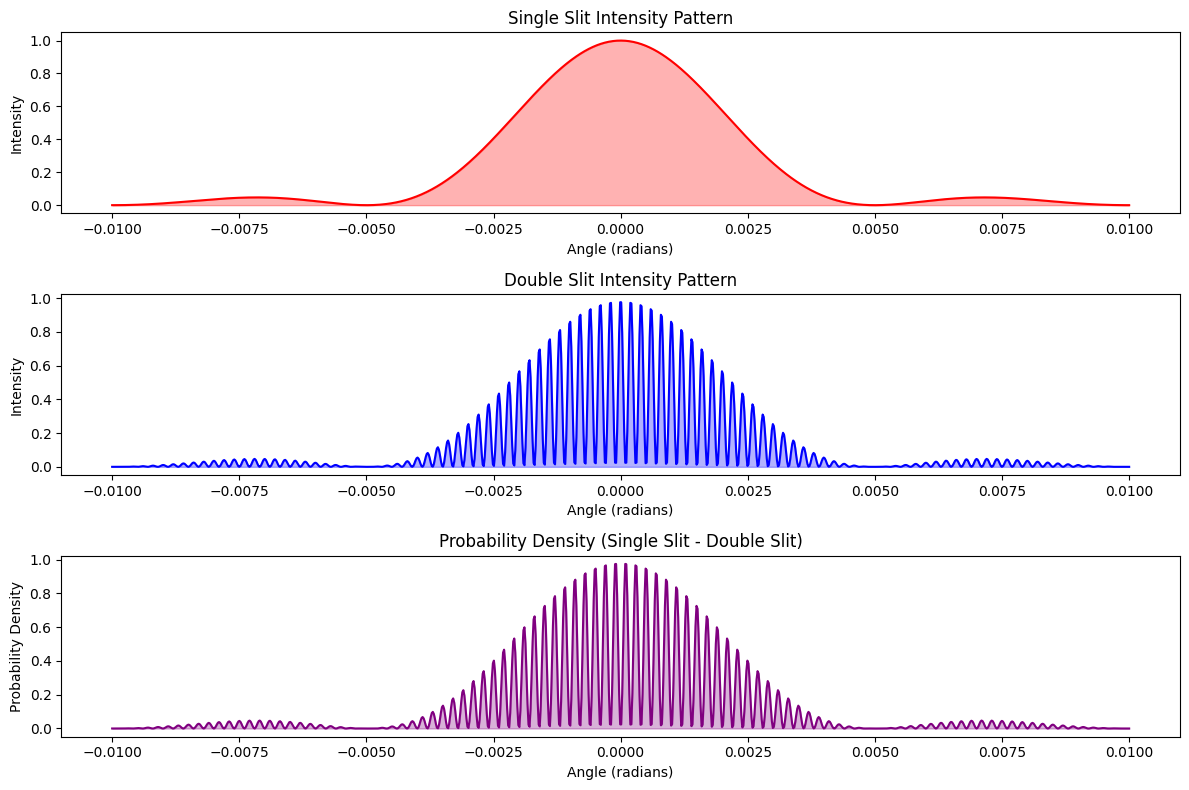

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the simulation
wavelength = 100e-9  # Wavelength of light in meters (500 nm for red light)
slit_width = 20e-6   # Width of each slit in meters
slit_separation = 500e-6  # Separation between slits in meters
screen_distance = 1.0  # Distance from slits to screen in meters

# Define the angle range for the simulation
theta = np.linspace(-0.01, 0.01, 1000)  # Angle in radians

# Calculate the single-slit diffraction pattern
beta = (np.pi * slit_width * np.sin(theta)) / wavelength
single_slit_intensity = (np.sin(beta) / beta)**2
single_slit_intensity[np.isnan(single_slit_intensity)] = 1  # Handle zero-division

# Calculate the double-slit interference pattern
alpha = (np.pi * slit_separation * np.sin(theta)) / wavelength
double_slit_intensity = (np.cos(alpha))**2 * single_slit_intensity

# Subtract single slit intensity from double slit to get the probability density
probability_density = single_slit_intensity - double_slit_intensity

# Plotting
plt.figure(figsize=(12, 8))

# Plot single-slit intensity pattern
plt.subplot(3, 1, 1)
plt.plot(theta, single_slit_intensity, color='red')
plt.fill_between(theta, single_slit_intensity, color='red', alpha=0.3)
plt.title("Single Slit Intensity Pattern")
plt.xlabel("Angle (radians)")
plt.ylabel("Intensity")

# Plot double-slit intensity pattern
plt.subplot(3, 1, 2)
plt.plot(theta, double_slit_intensity, color='blue')
plt.fill_between(theta, double_slit_intensity, color='blue', alpha=0.3)
plt.title("Double Slit Intensity Pattern")
plt.xlabel("Angle (radians)")
plt.ylabel("Intensity")

# Plot probability density (difference between double and single slit)
plt.subplot(3, 1, 3)
plt.plot(theta, probability_density, color='purple')
plt.fill_between(theta, probability_density, where=(probability_density > 0), color='purple', alpha=0.3)
plt.title("Probability Density (Single Slit - Double Slit)")
plt.xlabel("Angle (radians)")
plt.ylabel("Probability Density")

plt.tight_layout()
plt.show()
